<a href="https://colab.research.google.com/github/sant1dom/AI-Exam/blob/master/CodeCommentClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os
import nltk
nltk.download('stopwords')
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)



Running on TPU  grpc://10.74.141.34:8470
Number of replicas: 8


In [34]:
train_file_path = r"https://raw.githubusercontent.com/micheleintrevado/ML4MDE/main/archive/train.csv"
train_set = pd.read_csv(train_file_path)
train_set.drop(columns=['ID'], inplace=True)
train_set.head()

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


# Joining the title and abstract into a single text column

In [35]:
train_set["text"] = train_set["TITLE"] + " " + train_set["ABSTRACT"]
# train_set["text"] = train_set["ABSTRACT"]
train_set.drop(columns=["TITLE", "ABSTRACT"], inplace=True)

# Dataset Analysis

In [5]:
# Count the occurencies of each labels.
labels = train_set.columns.tolist()[2:]
counts = train_set[labels].sum().sort_values()

# Creating an horizontal bar graph.
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=counts.index, y=counts.values, palette='magma')

# Adding labels and title to the graph.
plt.xlabel('Number of occurrences')
plt.ylabel('Labels')
plt.title('Distribution of Label Occurrences')

# Show graph
plt.show()
print(f"The exact values for each class are:")
train_set[labels].sum().sort_values()

KeyboardInterrupt: 

# Dataset Preprocessing

In [36]:
contractions_dict = {
    "don't": "do not",
    "doesn't": "does not",
    "can't": "cannot",
    "isn't": "is not",
    "won't": "will not",
    "wasn't": "was not",
    "weren't": "were not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "couldn't": "could not",
    "shouldn't": "should not",
    "wouldn't": "would not",
    "it's": "it is",
    "I'm": "I am",
    "you're": "you are",
    "he's": "he is",
    "she's": "she is",
    "we're": "we are",
    "they're": "they are",
    "I've": "I have",
    "you've": "you have",
    "we've": "we have",
    "they've": "they have",
    "I'll": "I will",
    "you'll": "you will",
    "he'll": "he will",
    "she'll": "she will",
    "we'll": "we will",
    "they'll": "they will",
    "I'd": "I would",
    "you'd": "you would",
    "he'd": "he would",
    "she'd": "she would",
    "we'd": "we would",
    "they'd": "they would",
    "I won't": "I will not",
    "you won't": "you will not",
    "he won't": "he will not",
    "she won't": "she will not",
    "we won't": "we will not",
    "they won't": "they will not",
}

In [37]:
stop_words = set(nltk.corpus.stopwords.words('english'))

In [38]:
def prepare_text(text: str):
    text = text.lower()
    text = text.replace('"', '')
    text = re.sub("[^a-zA-Z]", " ", text)
    text = " ".join([contractions_dict.get(word, word) for word in text.split()])
    words = [word for word in text.split() if word not in stop_words and len(word) > 1]
    return " ".join(words).strip()

In [39]:
train_set['text'] = train_set['text'].apply(prepare_text)
train_set

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,text
0,1,0,0,0,0,0,reconstructing subject specific effect maps pr...
1,1,0,0,0,0,0,rotation invariance neural network rotation in...
2,0,0,1,0,0,0,spherical polyharmonics poisson kernels polyha...
3,0,0,1,0,0,0,finite element approximation stochastic maxwel...
4,1,0,0,1,0,0,comparative study discrete wavelet transforms ...
...,...,...,...,...,...,...,...
20967,1,1,0,0,0,0,contemporary machine learning guide practition...
20968,0,1,0,0,0,0,uniform diamond coatings wc co hard alloy cutt...
20969,1,0,0,0,0,0,analysing soccer games clustering conceptors p...
20970,0,0,1,1,0,0,efficient simulation left tail sum correlated ...


In [40]:
X_data = train_set[['text']].values
y_data = train_set.iloc[:, 0:-1].values
print(f"len X_data: {len(X_data)}, len y_data: {len(y_data)}")

len X_data: 20972, len y_data: 20972


In [75]:
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Embedding, Bidirectional, LSTM, Dropout, GlobalAveragePooling1D, SpatialDropout1D, Conv1D
from keras.models import Sequential
from keras.optimizers import Adam,SGD,RMSprop
import tensorflow as tf
import numpy as np
from sklearn.model_selection import KFold
import pickle
from keras.layers import TextVectorization
from keras.metrics import Precision, Recall, CategoricalAccuracy
from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss, accuracy_score, confusion_matrix

array(['reconstructing subject specific effect maps predictive models allow subject specific inference analyzing disease related alterations neuroimaging data given subject data inference made two levels global identifiying condition presence subject local detecting condition effect individual measurement extracted subject data global inference widely used local inference used form subject specific effect maps rarely used existing models often yield noisy detections composed dispersed isolated islands article propose reconstruction method named rsm improve subject specific detections predictive modeling approaches particular binary classifiers rsm specifically aims reduce noise due sampling error associated using finite sample examples train classifiers proposed method wrapper type algorithm used different binary classifiers diagnostic manner without information condition presence reconstruction posed maximum posteriori problem prior model whose parameters estimated training data class

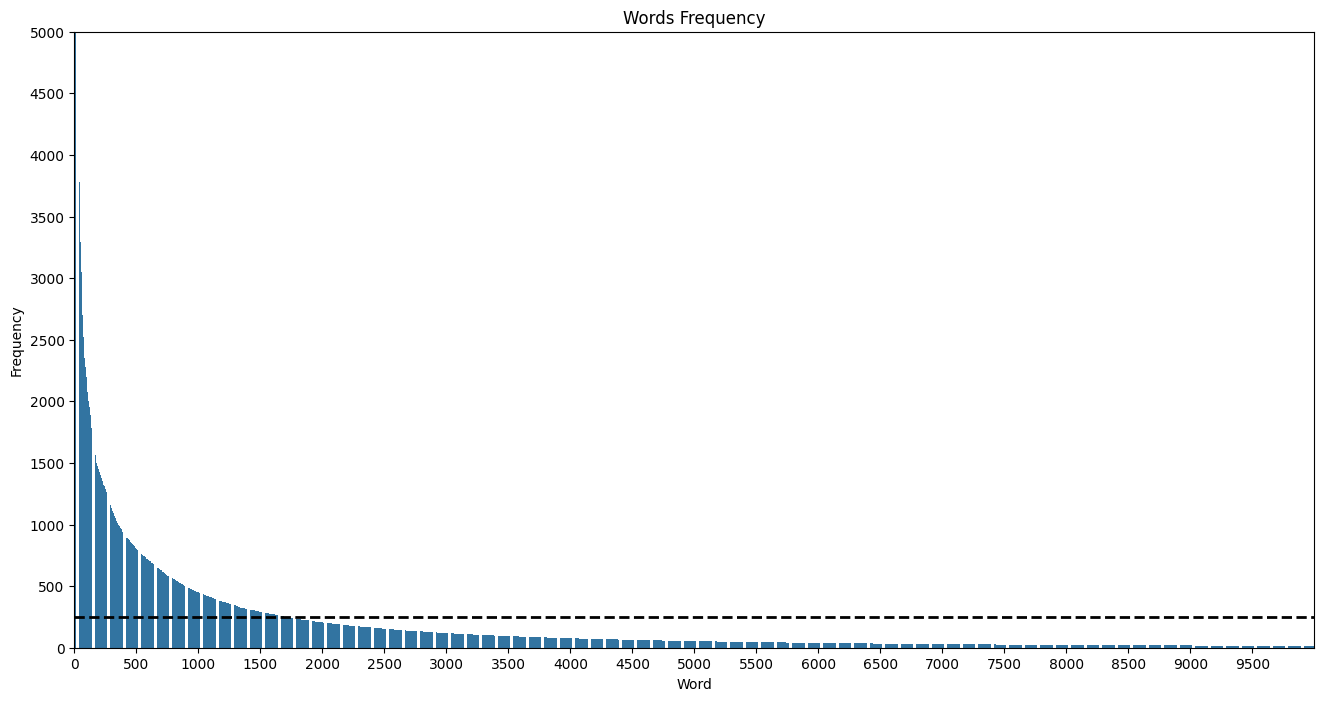

In [45]:
words = [word for text in X_data.flatten() for word in text.split()]
word_counts = Counter(words)

N = 10000 # Number of words to plot
interval = 500 # Interval for x-axis labels

# Get the N most common words and their frequencies
top_words = word_counts.most_common(N)
words, frequencies = zip(*top_words)

# Plot the word frequencies using Seaborn
plt.figure(figsize=(16, 8))
sns.barplot(x=range(len(words)), y=frequencies)
plt.title(f"Words Frequency")
plt.xlabel("Word")
plt.ylabel("Frequency")

# Build x-axis labels
x_labels = [f"{i * interval}" for i in range(N // interval)]

# Set x-axis labels
plt.xticks(range(0, N, interval), x_labels)

# Set y-axis limits and labels
plt.ylim(0, 5000)
plt.yticks(range(0, 5000 + 1, interval))

# Horizontal line
plt.axhline(y=250, color="black", linestyle='--', linewidth=2)

# Display the plot
plt.show()

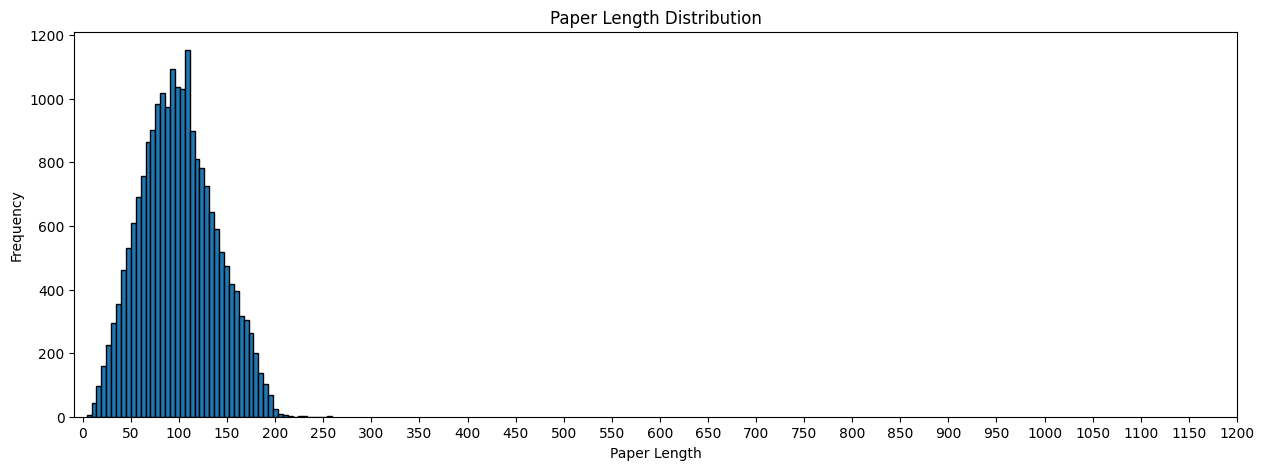

In [49]:
sentence_lengths = [len(paper.split()) for paper in X_data.flatten()]

# Plot the distribution of comment lengths using a histogram
plt.figure(figsize=(15, 5))
plt.hist(sentence_lengths, bins=50, edgecolor="black")
plt.title("Paper Length Distribution")
plt.xlabel("Paper Length")
plt.ylabel("Frequency")

# Set x-axis labels
plt.xticks(range(0, 1200 + 1, 50))

# Display the plot
plt.show()

In [50]:
# Text Vectorization
MAX_FEATURES = 1800
MAX_SEQUENCE = 200 # Maximum length of sequences
vectorizer = TextVectorization(max_tokens=MAX_FEATURES, output_sequence_length=MAX_SEQUENCE, output_mode='int')
vectorizer.adapt(X_data)

pickle.dump({'config': vectorizer.get_config(),
             'weights': vectorizer.get_weights()}
            , open("tv_layer.pkl", "wb"))

X = np.array(vectorizer(X_data))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.2, random_state=10)

Evaluate model

In [80]:
NUM_EPOCHS = 5
BATCH_SIZE = 32

def create_model():
    model = Sequential()

    model.add(Embedding(MAX_FEATURES + 1, 64))

    model.add(GlobalAveragePooling1D())

    model.add(Dense(6, activation="sigmoid"))

    model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")
    return model

In [81]:
# K-FOLD CROSS VALIDATION
NUM_FOLDS = 5
KF = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42) # K-Fold splitter
model = create_model()
print("K Cross Fold Validation START")
index = 1
for train_index, val_index in KF.split(X_train):
  print(f"Fold {index}")

  # Split the data into training and validation sets for the current fold
  X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
  y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]

  # Train the model on the current fold
  model.fit(X_fold_train, y_fold_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_fold_val, y_fold_val))

  # Evaluate the model on the validation set of the current fold
  scores = model.evaluate(X_fold_val, y_fold_val)

  print(f"Fold {index} => Loss: {scores[0]:.2f} and Accuracy: {scores[1]*100:.2f}%")
  index += 1

print("K Cross Fold Validation END")



K Cross Fold Validation START
Fold 1
Epoch 1/5
420/420 [==============================] - 6s 12ms/step - loss: 0.4740 - accuracy: 0.4375 - val_loss: 0.3944 - val_accuracy: 0.6019
Epoch 2/5
420/420 [==============================] - 6s 15ms/step - loss: 0.3551 - accuracy: 0.6962 - val_loss: 0.3206 - val_accuracy: 0.7431
Epoch 3/5
420/420 [==============================] - 4s 10ms/step - loss: 0.2967 - accuracy: 0.7379 - val_loss: 0.2811 - val_accuracy: 0.7485
Epoch 4/5
420/420 [==============================] - 6s 13ms/step - loss: 0.2660 - accuracy: 0.7578 - val_loss: 0.2593 - val_accuracy: 0.7569
Epoch 5/5
105/105 [==============================] - 1s 6ms/step - loss: 0.2441 - accuracy: 0.7619
Fold 1 => Loss: 0.24 and Accuracy: 76.19%
Fold 2
Epoch 1/5
420/420 [==============================] - 4s 9ms/step - loss: 0.2328 - accuracy: 0.7654 - val_loss: 0.2260 - val_accuracy: 0.7837
Epoch 2/5
420/420 [==============================] - 4s 10ms/step - loss: 0.2217 - accuracy: 0.7672 - val_

In [83]:
# Train the model with the entire dataset.
model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

# Display a summary of the model architecture and parameters
model.summary()

Epoch 1/5
525/525 [==============================] - 5s 9ms/step - loss: 0.1584 - accuracy: 0.7862
Epoch 2/5
525/525 [==============================] - 4s 8ms/step - loss: 0.1571 - accuracy: 0.7885
Epoch 3/5
525/525 [==============================] - 4s 8ms/step - loss: 0.1559 - accuracy: 0.7870
Epoch 4/5
525/525 [==============================] - 4s 8ms/step - loss: 0.1547 - accuracy: 0.7898
Epoch 5/5
525/525 [==============================] - 4s 8ms/step - loss: 0.1538 - accuracy: 0.7897
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, None, 64)          115264    
                                                                 
 global_average_pooling1d_5   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_30 (Dense)   

In [84]:
# Calculate metrics (Precision, Recall, Accuracy)
precision = Precision()
recall = Recall()
accuracy = CategoricalAccuracy()

y_predicted = model.predict(X_test)
y_predicted = (y_predicted > 0.5).astype(int)

# Calculate metrics.
precision.update_state(y_test, y_predicted)
precision_value = precision.result().numpy()
recall.update_state(y_test, y_predicted)
recall_value = recall.result().numpy()
accuracy.update_state(y_test, y_predicted)
accuracy_value = accuracy.result().numpy()
hamming_loss_value = hamming_loss(y_test, y_predicted)
f1_value = (2 * precision_value * recall_value) / (precision_value + recall_value)

print(f"Precision: {precision_value:.2f}")
print(f"Recall:{recall_value:.2f}")
print(f"Accuracy:{accuracy_value:.2f}")
print(f"Hamming Loss: {hamming_loss_value:.2f}")
print(f"F-1 Score: {f1_value:.2f}")

132/132 [==============================] - 0s 3ms/step
Precision: 0.83
Recall:0.76
Accuracy:0.78
Hamming Loss: 0.08
F-1 Score: 0.79


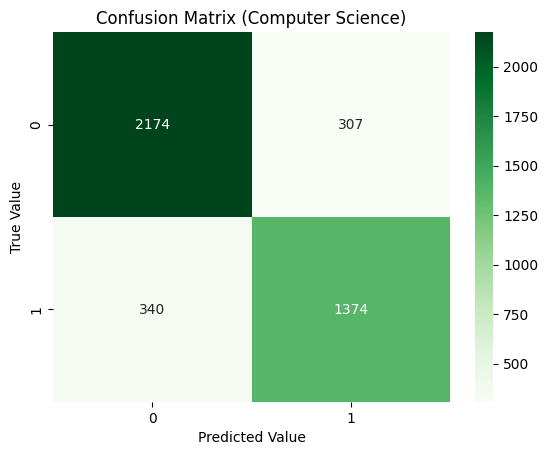

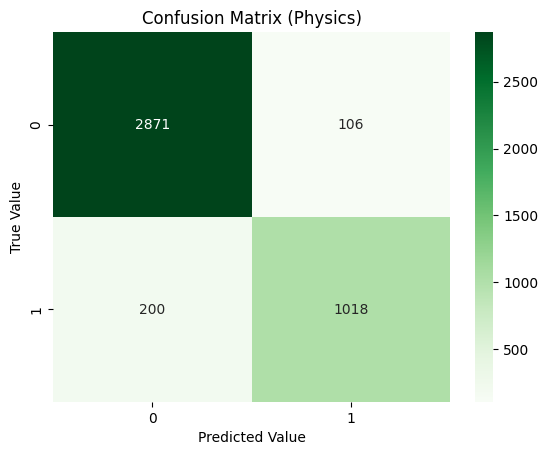

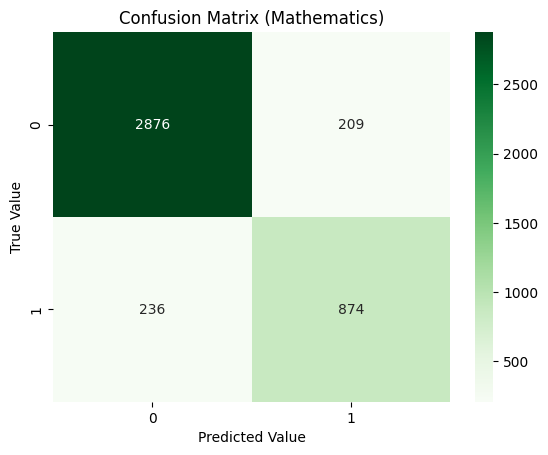

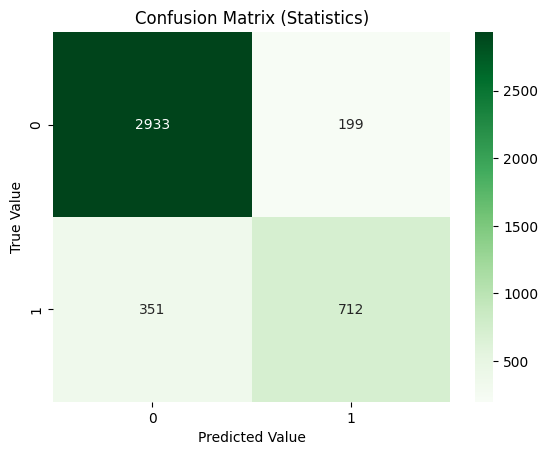

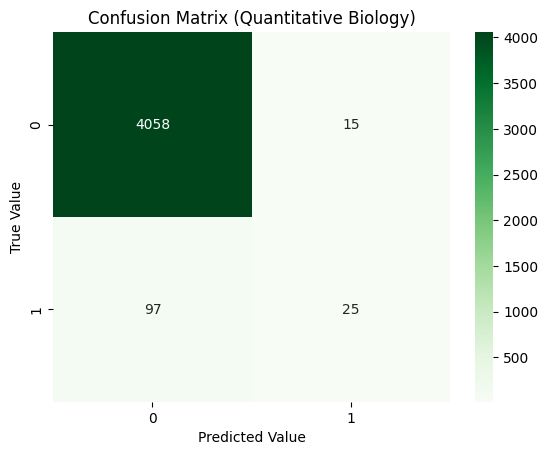

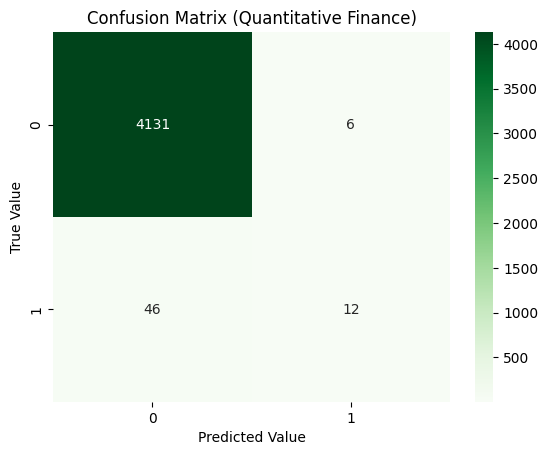

In [85]:
# List of labels corresponding to each toxicity category
labels = ["Computer Science", "Physics", "Mathematics", "Statistics", "Quantitative Biology", "Quantitative Finance"]

for label in range(6):
  # Extract the true labels and predicted labels for the specific toxicity category
  y_test_i = [row[label] for row in y_test]
  y_predicted_i = [row[label] for row in y_predicted]

  # Creating confusion matrix.
  CM = confusion_matrix(y_test_i, y_predicted_i)

  # Showing confusion matrix as a heatmap.
  sns.heatmap(CM, annot=True, fmt="d", cmap="Greens")
  plt.xlabel("Predicted Value")
  plt.ylabel("True Value")
  plt.title(f"Confusion Matrix ({labels[label]})")
  plt.show()

In [86]:
model.save('paper_classification.keras')

# For those classification problems that have a severe class imbalance, the default threshold can result in poor performance. So we decided to calculate thresholds for each category in order to improve the performances

In [126]:
y_pred = model.predict(X_test)
print(len(y_pred))
y_dict={"0":y_pred[:,0].flatten(),"1":y_pred[:,1].flatten(),'2':y_pred[:,2].flatten(),'3':y_pred[:,3].flatten(),'4':y_pred[:, 4].flatten(),'5':y_pred[:, 5].flatten()}
y_df=pd.DataFrame.from_dict(y_dict)

132/132 [==============================] - 1s 7ms/step
4195


In [128]:
from sklearn.metrics import precision_recall_curve

def find_threshold(y_test,y_prob):

    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

    plt.plot(recall, precision, marker='.', label='Model')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

    #Find best threshold
    min_diff=1
    for i in range(len(recall)):
        diff=abs(recall[i] -precision[i])
        if diff<min_diff:
            min_diff=diff
            best_threshold=thresholds[i]
            index=i

    print(f'Precision and Recall for threshold {best_threshold} = {precision[index]} and {recall[index]}')

    return best_threshold

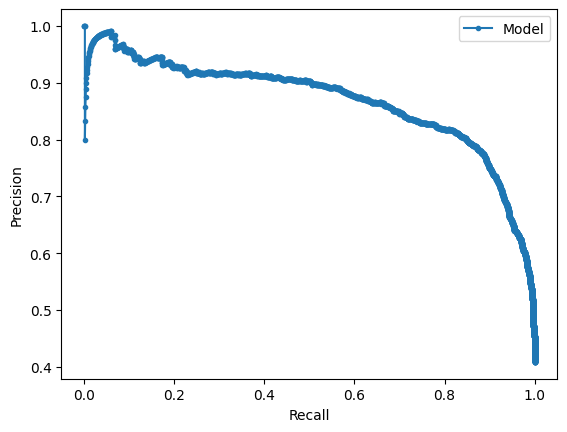

Precision and Recall for threshold 0.4750369191169739 = 0.8162193698949824 and 0.8162193698949824


In [130]:
threshold_cs=find_threshold(y_test[:,0],y_df.iloc[:,0])

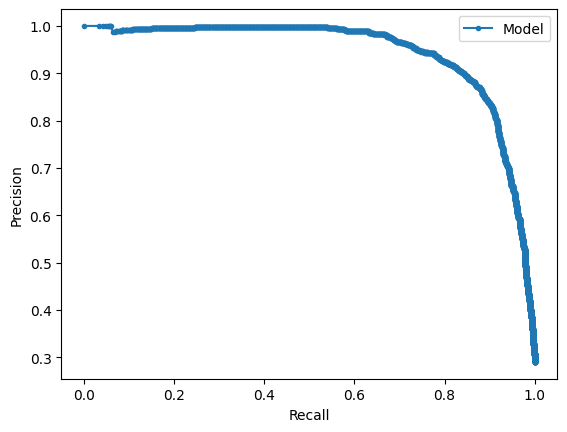

Precision and Recall for threshold 0.339783638715744 = 0.8719211822660099 and 0.8719211822660099


In [131]:
threshold_ph=find_threshold(y_test[:,1],y_df.iloc[:,1])

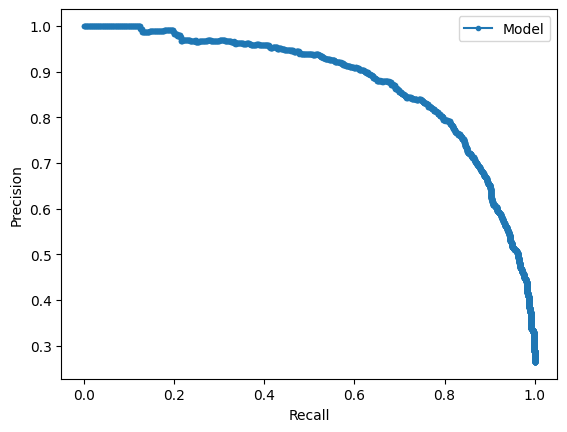

Precision and Recall for threshold 0.4709078073501587 = 0.7963963963963964 and 0.7963963963963964


In [132]:
threshold_math=find_threshold(y_test[:,2],y_df.iloc[:,2])

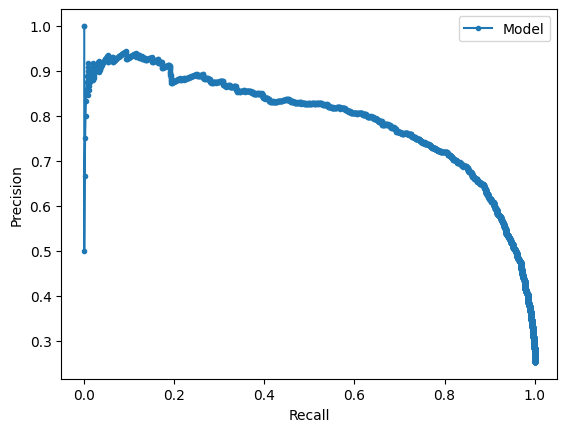

Precision and Recall for threshold 0.3894161581993103 = 0.7450611476952023 and 0.7450611476952023


In [133]:
threshold_stat=find_threshold(y_test[:,3],y_df.iloc[:,3])

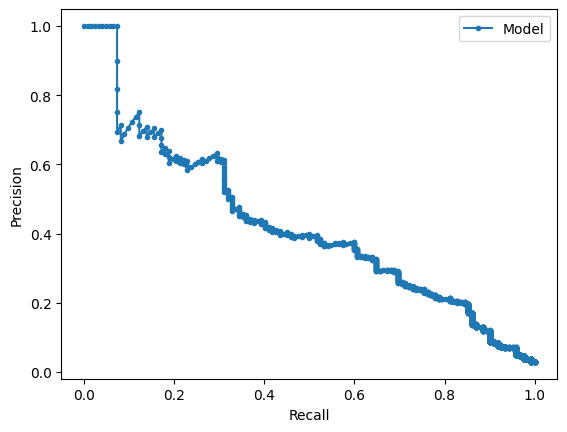

Precision and Recall for threshold 0.16634267568588257 = 0.4098360655737705 and 0.4098360655737705


In [134]:
threshold_qb=find_threshold(y_test[:,4],y_df.iloc[:,4])

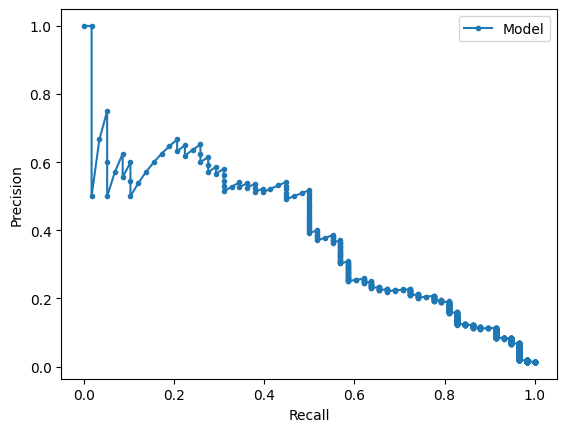

Precision and Recall for threshold 0.10505376756191254 = 0.5 and 0.5


In [135]:
threshold_qf=find_threshold(y_test[:,5],y_df.iloc[:,5])

In [160]:
# Load the trained model
checkpoint = tf.keras.models.load_model("paper_classification.keras")

# Load the configuration and weights of the TextVectorization layer from the pickle file
from_disk = pickle.load(open("tv_layer.pkl", "rb"))

# Create a new TextVectorization layer using the loaded configuration
new_v = TextVectorization.from_config(from_disk['config'])

# Call `adapt` with some dummy data to set up the state of the TextVectorization layer
new_v.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))

# Set the weights of the new TextVectorization layer to the loaded weights
new_v.set_weights(from_disk['weights'])

thr = {0:threshold_cs,1:threshold_ph,2:threshold_math,3:threshold_stat,4:threshold_qb,5:threshold_qf}

def format_prediction(title: str, abstract: str):
  text = title + abstract
  vectorized = new_v([text])

  # Make a prediction using the loaded model
  predicted = checkpoint.predict(vectorized, verbose=0)

  result = "Paper has been classified as: "
  labels_strings = []

  for index, label in enumerate(labels):
    if predicted[0][index] > thr[index]:
      labels_strings.append(label)
  if len(labels_strings)==0:
    return "Not in the model categories"

  return result + ", ".join(labels_strings)

# We implemented a web scraping function that given a link from the [IEEE Explore](https://ieeexplore.ieee.org) site can predict the class of the paper



In [163]:
import requests
from bs4 import BeautifulSoup

def extract_title_and_abstract(ieee_link):
    # Make a request to the IEEE link
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    response = requests.get(ieee_link, headers=headers)

    if response.status_code == 200:
        # Parse the HTML content
        soup = BeautifulSoup(response.text, 'html.parser')
        # Extract title
        title_element = soup.find("meta", property="og:title")["content"]
        title = title_element.strip() if title_element else None

        # Extract abstract
        abstract_element = soup.find("meta", property="og:description")["content"]
        abstract = abstract_element.strip() if abstract_element else None

        return title, abstract
    else:
        print(f"Failed to retrieve content. Status code: {response.status_code}")
        return None, None

while True:
  ieee_link = input("Insert the link of the paper from IEEE (type stop to block the execution): ")
  if ieee_link == "stop":
    break
  title, abstract = extract_title_and_abstract(ieee_link)
  if title and abstract:
      print("Title:", title)
      print("Abstract:", abstract)
      print("-"*50)
      print(format_prediction(title, abstract))
      print()
  else:
      print("Error extracting title and abstract.")


Insert the link of the paper from IEEE (type stop to block the execution): https://ieeexplore.ieee.org/document/10341142/
Title: Maturity assessment of software-driven medical technologies: a quantitative score derived from a quality standard for the research phase <sup>*</sup>
Abstract: Quantitatively assessing the level of readiness of medical technology improves its chance of successfully transfer from research to industry but remains a challenge. As many innovative medical devices are associated with or incorporate software, this article presents a methodology for evaluating the software maturity of a "Software-driven Medical Technology" (SdMT) during the research phase. A technological maturity model is developed by methodologically extracting relevant terms from the ISO/IEC 62304 standard, the main industry standard for medical device software, and results in a list of required software engineering artifacts. This list and the relative weight of the artifacts are used to establis

KeyboardInterrupt: Interrupted by user